# Summary of Training Scheme

### Stage 1: Train U-Net on 2D slices
- Compute loss weights based on ventricle volume, penalizing heavier on small ventricles
- Pad the images to a fixed length and save
- Train U-Net using weighted BCE and image augmentation

### Stage 2: Train Bidirectional LSTM in z dimension
- Freeze U-Net model weights
- Define LSTM model by sharing U-Net weights in z
- Make a generator that draws consecutive slices randomly
- Train LSTM using weighted BCE and image augmentation

### Stage 3: Fine-tune U-Net LSTM end-to-end (optional)
- Unfreeze U-Net model weights
- Train LSTM using weighted BCE and lower learning rate

In [152]:
import os
from glob import glob
import numpy as np
from tifffile import imread, imsave
from skimage import io
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.util import pad
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, ConvLSTM2D, Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import tensorflow as tf

ImportError: cannot import name 'izip'

# Stage 1: Train U-Net on 2D Slices

In [2]:
working_dir = '/data/datasets/ventricle_segmentation'
original_dir = os.path.join(working_dir, 'original_data')
padded_dir = os.path.join(working_dir, 'padded_data')

### Create padded syto and weights images

Check all segmentations for shapes, ventricle volumes, and class weights

In [3]:
def label_ventricles(seg):
    return label(seg, return_num=True)

def ventricle_volumes(labels):
    return np.asarray([p.area for p in regionprops(labels)])

In [16]:
seg_paths = glob(os.path.join(original_dir, 'seg*'))
syto_paths = glob(os.path.join(original_dir, 'syto_*_preprocessed.tif'))
seg_paths.sort()
syto_paths.sort()

seg_paths, syto_paths

(['/data/datasets/ventricle_segmentation/original_data/seg_d35_1.tif',
  '/data/datasets/ventricle_segmentation/original_data/seg_d35_2.tif',
  '/data/datasets/ventricle_segmentation/original_data/seg_d35_3.tif',
  '/data/datasets/ventricle_segmentation/original_data/seg_d35_4.tif',
  '/data/datasets/ventricle_segmentation/original_data/seg_d60_1.tif',
  '/data/datasets/ventricle_segmentation/original_data/seg_d60_2.tif'],
 ['/data/datasets/ventricle_segmentation/original_data/syto_d35_1_preprocessed.tif',
  '/data/datasets/ventricle_segmentation/original_data/syto_d35_2_preprocessed.tif',
  '/data/datasets/ventricle_segmentation/original_data/syto_d35_3_preprocessed.tif',
  '/data/datasets/ventricle_segmentation/original_data/syto_d35_4_preprocessed.tif',
  '/data/datasets/ventricle_segmentation/original_data/syto_d60_1_preprocessed.tif',
  '/data/datasets/ventricle_segmentation/original_data/syto_d60_2_preprocessed.tif'])

In [19]:
shapes = np.asarray([imread(path).shape for path in tqdm(seg_paths, total=len(seg_paths))])

target_shape = shapes.max(axis=0)
print(f"Target shape after padding: {target_shape}")

x_shape = (shapes[:, 0].sum(), *target_shape[1:])
print(f"Overall shape: {x_shape}")


Target shape after padding: [1500  894  894]
Overall shape: (5796, 894, 894)


Average ventricle volume: 32921 voxels (517 ventricles)


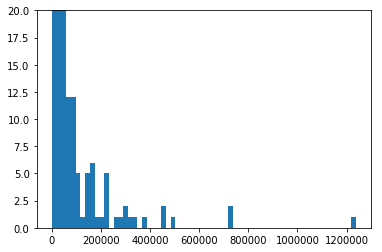

In [26]:
volumes = []
for path in tqdm(seg_paths, total=len(seg_paths)):
    seg = imread(path) > 0
    labels, nb_ventricles = label_ventricles(seg)
    volumes += list(ventricle_volumes(labels))
volumes = np.asarray(volumes)

ave_volume = volumes.mean()  # Reference ventricle volume
print(f"Average ventricle volume: {ave_volume:.0f} voxels ({len(volumes)} ventricles)")

plt.hist(volumes, bins=64)
plt.ylim([0, 20])
plt.show()

Define weight images, padding functions, and class weights

In [27]:
def volume_weighting(v, v0, wmin, wmax):
    return wmin + (wmax - wmin) * np.exp(-v / v0)

def seg_to_weights(seg, v0, wmin, wmax):
    labels, nb_ventricles = label_ventricles(seg)
    volumes = ventricle_volumes(labels)
    foreground_weights = np.zeros(seg.shape)
    if nb_ventricles > 0:
        for i, volume in tqdm(enumerate(volumes), total=len(volumes)):
            loc = np.where(labels == i + 1)
            foreground_weights[loc] = volume_weighting(volume, v0, wmin, wmax)
    return foreground_weights * seg + (1 - seg)

def xy_padding(img, shape, cval=0):
    original_shape = np.asarray(img.shape)
    target_shape = np.asarray(shape)
    assert np.all(original_shape <= target_shape)
    padding = target_shape - original_shape
    pad_width = ((0, 0), (0, padding[1]), (0, padding[2]))  # No padding in z
    padded = pad(img, pad_width, 'constant', constant_values=cval)
    return padded

In [98]:
total_volume = volumes.sum()
imbalance = total_volume / np.asarray(x_shape).prod()
print(f"{imbalance * 100:.2f}% of voxels are ventricles")

0.4% of voxels are ventricles


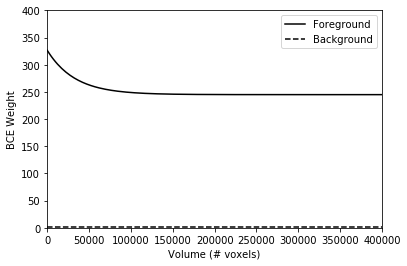

In [102]:
v0 = ave_volume
w0 = (1 / imbalance)
wmin = 0.9 * w0
wmax = 1.0 * w0

v = np.linspace(0, volumes.max(), 500)
w = volume_weighting(v, v0, wmin, wmax)

%matplotlib inline
plt.plot(v, w, 'k-', label='Foreground')
plt.plot(v, np.ones(len(v)), 'k--', label='Background')
plt.xlabel('Volume (# voxels)')
plt.ylabel('BCE Weight')
plt.ylim([0, 400])
plt.xlim([0, 4e5])
plt.legend()
plt.show()

Save padded syto and weight images

In [103]:
os.makedirs(padded_dir, exist_ok=True)

for syto_path, seg_path in tqdm(zip(syto_paths, seg_paths), total=len(seg_paths)):
    syto = imread(syto_path)
    seg = imread(seg_path) > 0
    
    weights = seg_to_weights(seg, ave_volume, wmin, wmax)
    syto_padded = xy_padding(syto, target_shape, cval=0)
    weights_padded = xy_padding(weights, target_shape, cval=1)
    
    imsave(os.path.join(padded_dir, os.path.basename(syto_path)), syto_padded, compress=1)
    imsave(os.path.join(padded_dir, os.path.basename(seg_path)), weights_padded, compress=1)

### Train U-Net with weighted BCE and image augmentation

Create train and test sets

In [292]:
zstart = np.asarray([0] + list(np.cumsum(shapes[:, 0])))
zstop = zstart[1:]

x = np.empty(x_shape, np.float32)
y = np.empty(x_shape, np.float32)
for i, (syto_path, seg_path) in tqdm(enumerate(zip(syto_paths, seg_paths)), total=len(seg_paths)):
    x[zstart[i]:zstop[i]] = imread(os.path.join(padded_dir, os.path.basename(syto_path)))
    y[zstart[i]:zstop[i]] = imread(os.path.join(padded_dir, os.path.basename(seg_path)))
    
x.shape, y.shape, x.dtype, y.dtype, x.max(), y.max()

((5796, 894, 894),
 (5796, 894, 894),
 dtype('float32'),
 dtype('float32'),
 5.5053763,
 326.60254)

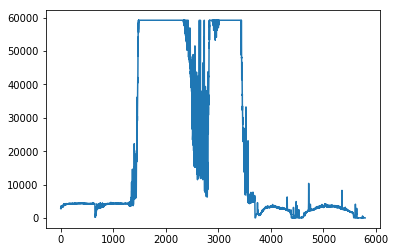

In [48]:
# Before scaling
maxvals = x.max(axis=-1).max(axis=-1)

plt.plot(maxvals)
plt.show()

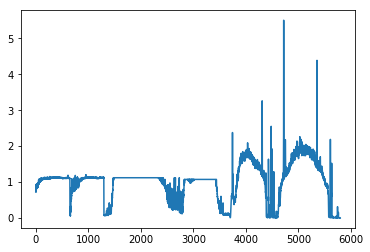

In [105]:
# After scaling
maxvals = x.max(axis=-1).max(axis=-1)

plt.plot(maxvals)
plt.show()

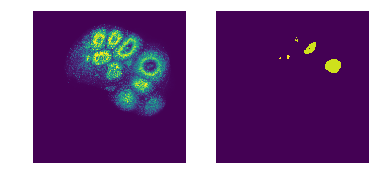

In [34]:
plt.subplot(121)
plt.imshow(x[-400], clim=[0, 1])
plt.axis('off')
plt.subplot(122)
plt.imshow(y[-400])
plt.axis('off')
plt.show()

In [293]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=76)

x_train.shape, x_test.shape

((4636, 894, 894), (1160, 894, 894))

In [294]:
x_train = xy_padding(x_train, (len(x_train), 1024, 1024), cval=0)
y_train = xy_padding(y_train, (len(y_train), 1024, 1024), cval=1)
x_test = xy_padding(x_test, (len(x_test), 1024, 1024), cval=0)
y_test = xy_padding(y_test, (len(y_test), 1024, 1024), cval=1)

In [295]:
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

x_train.shape, x_test.shape

((4636, 1024, 1024, 1), (1160, 1024, 1024, 1))

Define U-Net model

In [702]:
base_filters = 8
pool_size = (2, 2)

conv_args = {'activation': 'relu',
             'padding': 'same',
#              'kernel_regularizer': tf.keras.regularizers.L1L2(l2=1e-6)
             #'kernel_initializer': 'he_normal'
            }

inputs = Input((None, None, 1))

# Encoder
conv1 = Conv2D(base_filters, 3, **conv_args)(inputs)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = Conv2D(base_filters, 3, **conv_args)(conv1)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=pool_size)(conv1)

conv2 = Conv2D(base_filters * 2, 3, **conv_args)(pool1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = Conv2D(base_filters * 2, 3, **conv_args)(conv2)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=pool_size)(conv2)

conv3 = Conv2D(base_filters * 4, 3, **conv_args)(pool2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = Conv2D(base_filters * 4, 3, **conv_args)(conv3)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=pool_size)(conv3)

conv4 = Conv2D(base_filters * 8, 3, **conv_args)(pool3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
conv4 = Conv2D(base_filters * 8, 3, **conv_args)(conv4)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=pool_size)(drop4)

conv5 = Conv2D(base_filters * 16, 3, **conv_args)(pool4)
conv5 = tf.keras.layers.BatchNormalization()(conv5)
conv5 = Conv2D(base_filters * 16, 3, **conv_args)(conv5)
conv5 = tf.keras.layers.BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)
pool5 = MaxPooling2D(pool_size=pool_size)(drop5)

conv6 = Conv2D(base_filters * 32, 3, **conv_args)(pool5)
conv6 = tf.keras.layers.BatchNormalization()(conv6)
conv6 = Conv2D(base_filters * 32, 3, **conv_args)(conv6)
conv6 = tf.keras.layers.BatchNormalization()(conv6)
drop6 = Dropout(0.5)(conv6)
pool6 = MaxPooling2D(pool_size=pool_size)(drop6)

conv7 = Conv2D(base_filters * 64, 3, **conv_args)(pool6)
conv7 = tf.keras.layers.BatchNormalization()(conv7)
conv7 = Conv2D(base_filters * 64, 3, **conv_args)(conv7)
conv7 = tf.keras.layers.BatchNormalization()(conv7)
drop7 = Dropout(0.5)(conv7)

# Decoder
up8 = tf.keras.layers.Conv2DTranspose(base_filters * 32, 2, strides=pool_size, **conv_args)(drop7)
merge8 = concatenate([drop6,up8], axis = 3)
conv8 = Conv2D(base_filters * 32, 3, **conv_args)(merge8)
conv8 = tf.keras.layers.BatchNormalization()(conv8)
conv8 = Conv2D(base_filters * 32, 3, **conv_args)(conv8)
conv8 = tf.keras.layers.BatchNormalization()(conv8)

up9 = tf.keras.layers.Conv2DTranspose(base_filters * 16, 2, strides=pool_size, **conv_args)(conv8)
merge9 = concatenate([drop5,up9], axis = 3)
conv9 = Conv2D(base_filters * 16, 3, **conv_args)(merge9)
conv9 = tf.keras.layers.BatchNormalization()(conv9)
conv9 = Conv2D(base_filters * 16, 3, **conv_args)(conv9)
conv9 = tf.keras.layers.BatchNormalization()(conv9)

up10 = tf.keras.layers.Conv2DTranspose(base_filters * 8, 2, strides=pool_size, **conv_args)(conv9)
merge10 = concatenate([drop4,up10], axis = 3)
conv10 = Conv2D(base_filters * 8, 3, **conv_args)(merge10)
conv10 = tf.keras.layers.BatchNormalization()(conv10)
conv10 = Conv2D(base_filters * 8, 3, **conv_args)(conv10)
conv10 = tf.keras.layers.BatchNormalization()(conv10)

up11 = tf.keras.layers.Conv2DTranspose(base_filters * 4, 2, strides=pool_size, **conv_args)(conv10)
merge11 = concatenate([conv3,up11], axis = 3)
conv11 = Conv2D(base_filters * 4, 3, **conv_args)(merge11)
conv11 = tf.keras.layers.BatchNormalization()(conv11)
conv11 = Conv2D(base_filters * 4, 3, **conv_args)(conv11)
conv11 = tf.keras.layers.BatchNormalization()(conv11)

up12 = tf.keras.layers.Conv2DTranspose(base_filters * 2, 2, strides=pool_size, **conv_args)(conv11)
merge12 = concatenate([conv2,up12], axis = 3)
conv12 = Conv2D(base_filters * 2, 3, **conv_args)(merge12)
conv12 = tf.keras.layers.BatchNormalization()(conv12)
conv12 = Conv2D(base_filters * 2, 3, **conv_args)(conv12)
conv12 = tf.keras.layers.BatchNormalization()(conv12)

up13 = tf.keras.layers.Conv2DTranspose(base_filters, 2, strides=pool_size, **conv_args)(conv12)
merge13 = concatenate([conv1,up13], axis = 3)
conv13 = Conv2D(base_filters, 3, **conv_args)(merge13)
conv13 = tf.keras.layers.BatchNormalization()(conv13)
conv13 = Conv2D(base_filters, 3, **conv_args)(conv13)
conv13 = tf.keras.layers.BatchNormalization()(conv13)

conv14 = Conv2D(1, 1, activation='sigmoid')(conv13)

In [703]:
unet = Model(inputs, conv14)

In [704]:
def dice_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(K.batch_flatten(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.batch_flatten(y_true), -1) + K.sum(K.batch_flatten(y_pred), -1)
    return (2 * intersection + smooth) / (sum_ + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coef(y_true, y_pred, smooth) #-K.log(K.clip(dice, K.epsilon(), None))

def jaccard_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(K.batch_flatten(K.abs(y_true * y_pred)), axis=-1)
    sum_ = K.sum(K.batch_flatten(K.abs(y_true) + K.abs(y_pred)), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def weighted_bce(y_true, y_pred, weights):
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = weights * bce
    return K.mean(K.batch_flatten(weighted_bce), axis=-1)

def weighted_bce2(y_true, y_pred):
    # get counts in y_true
    n_foreground = K.sum(K.batch_flatten(y_true), -1)
    n_background = K.sum(K.batch_flatten(1 - y_true), -1)
    w_foreground = n_background / (n_foreground + n_background)
    beta = 10
    bce = -1.0 * (beta * y_true * K.log(K.clip(y_pred, K.epsilon(), None)) + (1 - y_true) * K.log(K.clip(1 - y_pred, K.epsilon(), None)))
    wbce = (w_foreground + 100) / ((1 - w_foreground) + 100) * y_true * bce + (1 - y_true) * bce
    return K.mean(K.batch_flatten(wbce), axis=-1)

def custom_loss(weights, y_pred):
    y_true = K.cast(weights > 1.0, 'float32')
    wbce = weighted_bce2(y_true, y_pred)
    dloss = dice_loss(y_true, y_pred)
    return wbce + 0.1 * dloss

def pixel_accuracy(weights, y_pred):
    y_true = K.cast(weights > 1.0, 'float32')
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)

In [705]:
unet.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_543 (Conv2D)             (None, None, None, 8 80          input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_434 (BatchN (None, None, None, 8 32          conv2d_543[0][0]                 
__________________________________________________________________________________________________
conv2d_544 (Conv2D)             (None, None, None, 8 584         batch_normalization_434[0][0]    
___________________________________________________________________________________________

In [16]:
# unet.load_weights(os.path.join(working_dir, 'unet_weights.h5'))

In [706]:
unet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
              loss=custom_loss, 
              metrics=[pixel_accuracy, dice_coef])

In [463]:
image_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=45,
                                  # zoom_range=(0.5, 1.5)
                                  )

weights_datagen = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=45,
                                    # zoom_range=(0.5, 1.5)
                                    )

In [441]:
y_train.min(), y_train.max()

(1.0, 326.60254)

In [479]:
batch_size = 3

xgen = image_datagen.flow(x_train, batch_size=batch_size, seed=76)
ygen = weights_datagen.flow(y_train, batch_size=batch_size, seed=76)

def generate_batch():
    while True:
        yield next(xgen), next(ygen)

gen = generate_batch()

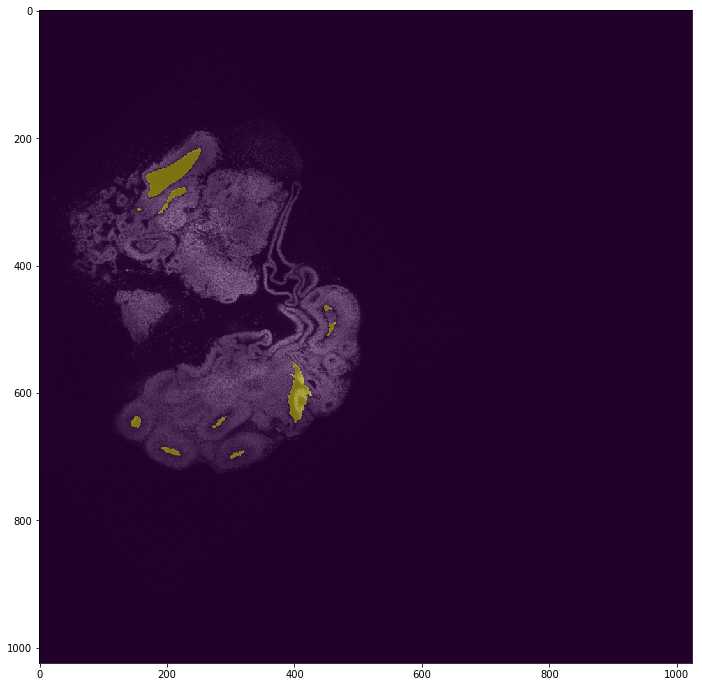

In [482]:
# test that datagen is working
x_sample, y_sample = next(gen)

plt.figure(figsize=(12, 12))
# plt.subplot(121)
plt.imshow(x_sample[0, :, :, 0], cmap='gray')
plt.imshow(y_sample[0, :, :, 0], alpha=0.5, clim=[1, 100])
# plt.subplot(122)

plt.show()

In [ ]:
epochs = 100

unet.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test))

# unet.fit_generator(gen,
#                    steps_per_epoch=len(x_train) / batch_size, 
#                    epochs=epochs,
#                    validation_data=(x_test, y_test > 2))

Train on 4636 samples, validate on 1160 samples
Epoch 1/100
4636/4636 [==============================] - 429s 92ms/sample - loss: 0.6454 - pixel_accuracy: 0.9404 - dice_coef: 0.8493 - val_loss: 0.4651 - val_pixel_accuracy: 0.9897 - val_dice_coef: 0.8083
Epoch 2/100
3534/4636 [=====================>........] - ETA: 1:26 - loss: 0.3638 - pixel_accuracy: 0.9958 - dice_coef: 0.7365

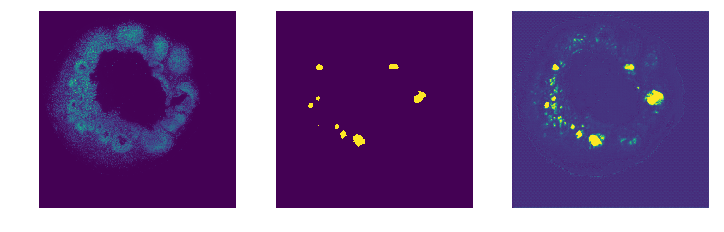

In [701]:
idx = 100

x_sample = x_test[idx][np.newaxis]
y_sample = y_test[idx]
y_sample_pred = unet.predict(x_sample)

%matplotlib inline
plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.imshow(x_sample[0, :, :, 0])
plt.axis('off')
plt.subplot(132)
plt.imshow(y_sample[:, :, 0] > 1, clim=[0, 1])
plt.axis('off')
plt.subplot(133)
plt.imshow(y_sample_pred[0, :, :, 0], clim=[0, 1])
plt.axis('off')
plt.show()

In [224]:
unet.save_weights(os.path.join(working_dir, 'unet_weights.h5'))

In [168]:
# unet.save(os.path.join(working_dir, 'unet.h5'))  # Doesn't work with custom loss

### Test UNet on whole organoid

In [549]:
y_pred = np.empty_like(y_test)
for i in range(len(y_pred)):
    y_pred[i] = unet.predict(x_test[i][np.newaxis])[0]
y_pred.shape

(1160, 1024, 1024, 1)

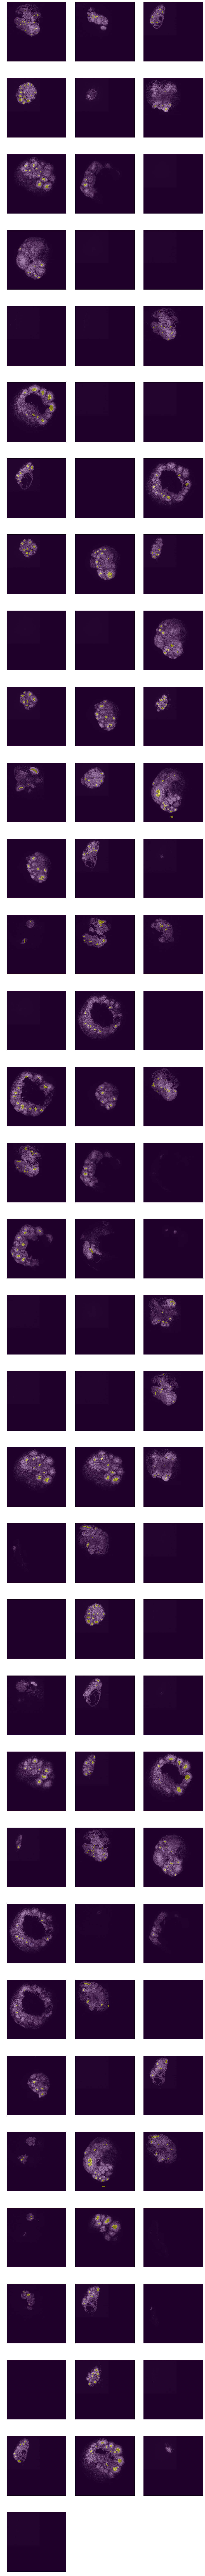

In [550]:
zstep = 5
columns = 3
figsize = (16, 200)

n = 500 // zstep # len(y_pred) // zstep
plt.figure(figsize=figsize)
for z in range(n):
    plt.subplot(n // columns + 1, columns, z+1)
    plt.imshow(x_test[zstep * z, :, :, 0], clim=[0, 1], cmap='gray')
    plt.imshow(y_pred[zstep * z, :, :, 0], clim=[0, 1], alpha=0.5)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [271]:
def roc(y_pred, y_true, threshold):
    y_pred_binary = (y_pred > threshold)

    tp_img = np.logical_and(y_pred_binary, y_true)
    fp_img = np.logical_and(y_pred_binary, np.logical_not(y_true))
    tn_img = np.logical_and(np.logical_not(y_pred_binary), np.logical_not(y_true))
    fn_img = np.logical_and(np.logical_not(y_pred_binary), y_true)

    tp = tp_img.sum()
    fp = fp_img.sum()
    tn = tn_img.sum()
    fn = fn_img.sum()
    
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)

    return fpr, recall, precision

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


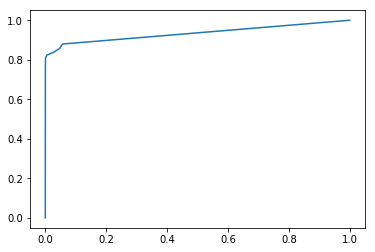

In [308]:
thresholds = np.linspace(0, 1, 10)
y_true = y_test > 1

roc_curve = np.asarray([roc(y_pred, y_true, t) for t in tqdm(thresholds, total=len(thresholds))])

plt.plot(roc_curve[:, 0], roc_curve[:, 1])
plt.show()

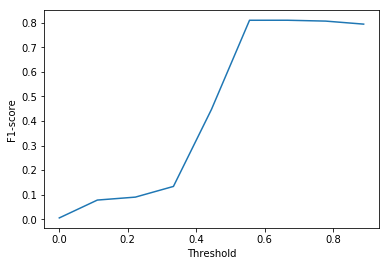

In [311]:
fscore = 2 * roc_curve[:, 1] * roc_curve[:, 2] / (roc_curve[:, 1] + roc_curve[:, 2])

plt.plot(thresholds, fscore)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

# Stage 2: Train Bidirectional LSTM in z dimension

Freeze U-Net model weights

In [352]:
for layer in unet.layers:
#     layer.trainable = False
    layer.trainable = True

Define LSTM model

In [312]:
x_in = Input((None, None, None, 1))
x = tf.keras.layers.TimeDistributed(unet)(x_in)  # (z, y, x, c)
# x = Bidirectional(ConvLSTM2D(64, (3, 3), padding='same'))(x)
x = tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
x = x[:, 1]
x_out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

In [313]:
lstm = Model(x_in, x_out)

In [314]:
lstm.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, None, None, None, 0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, None, None,  7771297   
_________________________________________________________________
conv3d_6 (Conv3D)            (None, None, None, None,  3584      
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, None, 128)] 0         
_________________________________________________________________
conv2d_260 (Conv2D)          (None, None, None, 1)     129       
Total params: 7,775,010
Trainable params: 3,713
Non-trainable params: 7,771,297
_________________________________________________________________


Draw consecutive slices

In [227]:
zstart = np.asarray([0] + list(np.cumsum(shapes[:, 0])))
zstop = zstart[1:]
x = np.empty(x_shape, np.float32)
y = np.empty(x_shape, np.float32)
for i in tqdm(range(n), total=n):
    syto_name = filenames[i+n]
    weights_name = filenames[i]
    syto_img = imread(os.path.join(padded_dir, syto_name))
    weights_img = imread(os.path.join(padded_dir, weights_name))
    x[zstart[i]:zstop[i]] = syto_img
    y[zstart[i]:zstop[i]] = weights_img
    
x.shape, y.shape, x.dtype, y.dtype, x.max(), y.max()

((5796, 894, 894),
 (5796, 894, 894),
 dtype('float32'),
 dtype('float32'),
 59235.0,
 353.81964)

In [225]:
# Use first organoid as test set
x_test, y_test = x[:zstop[0]], y[:zstop[0]]
x_train, y_train = x[zstop[0]:], y[zstop[0]:]
zstart_train = zstart[1:] - len(x_test)
zstart_test = zstart[:2]

x_test.shape, x_train.shape, y_test.shape, y_train.shape

((650, 894, 894), (5146, 894, 894), (650, 894, 894), (5146, 894, 894))

In [226]:
x_train = xy_padding(x_train, (len(x_train), 1024, 1024), cval=0)
y_train = xy_padding(y_train, (len(y_train), 1024, 1024), cval=1)
x_test = xy_padding(x_test, (len(x_test), 1024, 1024), cval=0)
y_test = xy_padding(y_test, (len(y_test), 1024, 1024), cval=1)

x_test.shape, x_train.shape, y_test.shape, y_train.shape

((650, 1024, 1024), (5146, 1024, 1024), (650, 1024, 1024), (5146, 1024, 1024))

In [227]:
x_train, y_train = x_train[..., np.newaxis], x_train[..., np.newaxis]
x_test, y_test = x_test[..., np.newaxis], y_test[..., np.newaxis]

x_test.shape, x_train.shape, y_test.shape, y_train.shape

((650, 1024, 1024, 1),
 (5146, 1024, 1024, 1),
 (650, 1024, 1024, 1),
 (5146, 1024, 1024, 1))

In [303]:
def generate_consecutive(x, y, edges, z=3, width=512):
    
    while True:
        # Get a random z-index away from edges
        invalid = True
        while invalid:
            idx = np.random.randint(0, len(x), 1)[0]
            if np.all(np.abs(idx - edges) > (z // 2)): 
                invalid = False
                
        # Get a random ROI
        xstart = np.random.randint(0, x.shape[2] - width, 1)[0]
        ystart = np.random.randint(0, x.shape[1] - width, 1)[0]
        xstop = xstart + width
        ystop = ystart + width
                
        # Extract slices from dataset
        start = idx-z//2
        stop = start + z
        x_batch = x[start:stop, ystart:ystop, xstart:xstop][np.newaxis]
        y_batch = y[idx, ystart:ystop, xstart:xstop][np.newaxis]
        
        yield x_batch, y_batch
    
train_gen = generate_consecutive(x_train, y_train, zstart_train)

x_batch, y_batch = next(train_gen)
x_batch.shape, y_batch.shape

((1, 3, 512, 512, 1), (1, 512, 512, 1))

In [304]:
test_gen = generate_consecutive(x_test, y_test, zstart_test)

x_batch, y_batch = next(test_gen)
x_batch.shape, y_batch.shape

((1, 3, 512, 512, 1), (1, 512, 512, 1))

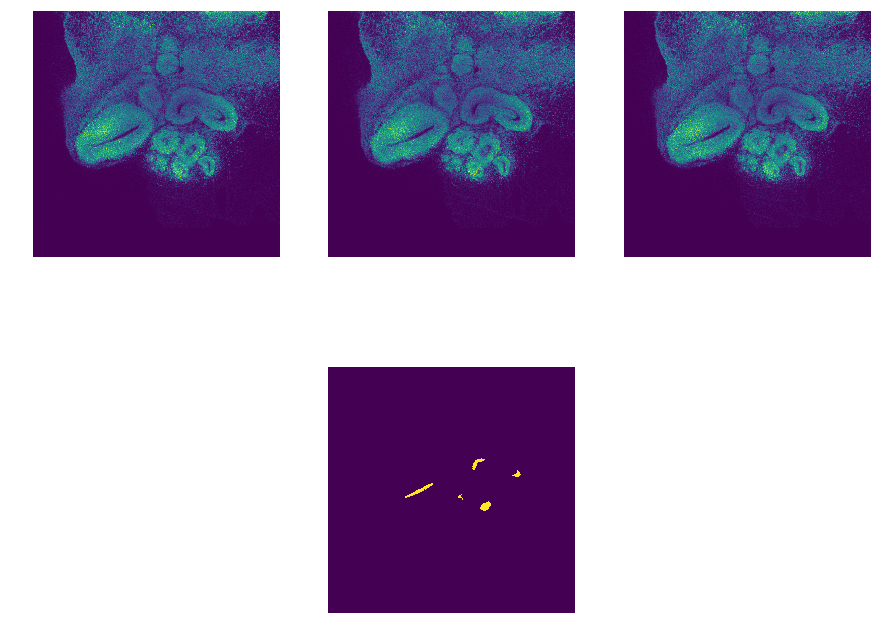

In [285]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 1)
plt.imshow(x_batch[0, 0, :, :, 0])
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(x_batch[0, 1, :, :, 0])
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(x_batch[0, 2, :, :, 0])
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(y_batch[0, :, :, 0])
plt.axis('off')
plt.show()

Train LSTM using weighted BCE

In [319]:
lstm.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
              loss=weighted_bce,
              metrics=[custom_accuracy])

In [320]:
lstm.fit_generator(train_gen,
                   steps_per_epoch=len(x_train),
                   epochs=100,
                   validation_data=test_gen,
                   validation_steps=len(x_test))

Epoch 1/100
1141/5146 [=====>........................] - ETA: 5:47 - loss: 3.1347 - custom_accuracy: 0.4058

KeyboardInterrupt: 

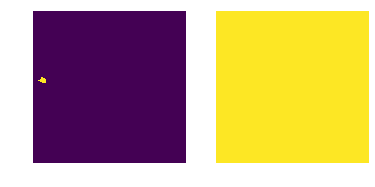

In [326]:
x_sample, y_sample = next(test_gen)
y_sample_pred = lstm.predict(x_sample)

plt.subplot(121)
plt.imshow(y_sample[0, :, :, 0], clim=[1, 5])
plt.axis('off')
plt.subplot(122)
plt.imshow(y_sample_pred[0, :, :, 0], clim=[0, 1])
plt.axis('off')
plt.show()